#Perkenalan

Graded Challenge 7

Nama : M Hafiz Juliant
Batch: RMT-028

Objective:  Suicidal Tweet Detection merupakan upaya penting dalam bidang kesehatan mental dan analisis media sosial. Dalam era digital, platform seperti Twitter menjadi tempat di mana individu sering mengungkapkan pikiran dan emosi mereka secara terbuka. Melalui analisis teks dan deep learning dapat mengidentifikasi pola-pola bahasa yang mengindikasikan pikiran atau perilaku bunuh diri.

# Import Library

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [2]:
# Basic
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from scipy.stats import kruskal
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Analyze tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import keras_tuner
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as tf_hub
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
nltk.download('wordnet')
import re
import pickle
print('imported :)')

imported :)


<ipython-input-2-3115a7452385>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Data Loading

In [3]:
!pip install -q kaggle

token = '{"username":"mhafizjuliant","key":"0d912d114417dd6cb39daa92e1a2b37a"}'

with open("kaggle.json", "w") as f:
  f.write(token)

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d "aunanya875/suicidal-tweet-detection-dataset"

  0% 0.00/88.3k [00:00<?, ?B/s]
100% 88.3k/88.3k [00:00<00:00, 43.5MB/s]


In [5]:
!unzip suicidal-tweet-detection-dataset.zip

Archive:  suicidal-tweet-detection-dataset.zip
  inflating: Suicide_Ideation_Dataset(Twitter-based).csv  


In [6]:
df = pd.read_csv('Suicide_Ideation_Dataset(Twitter-based).csv')
df.head()

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


# Exploratory Data Analys

In [7]:
#menunjukkan informasi tabel
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.0+ KB


In [8]:
#menunjukkan missing value
df.isnull().sum()

Tweet      2
Suicide    0
dtype: int64

In [9]:
#menghapus missing value
df.dropna(inplace=True)

Dari informasi diatas didapatkan informasi :
- terdiri dari 1787 baris dan 2 kolom
- terdapat 2 data missing value pada kolom Tweet

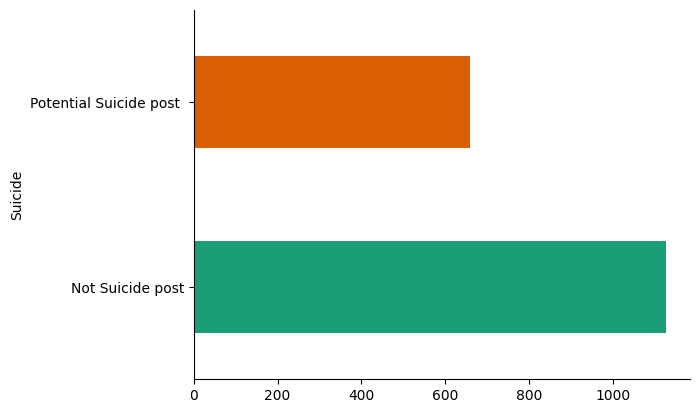

In [10]:
# @title Distribution of Suicide

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Suicide').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Berdasarkan visualisasi diatas 1/3 dari total jumlah tweet berisi tentang post yang memiliki potensial bunuh diri dan 2/3 nya merupakan tweet  yang tidak berpotensi bunuh diri

<ipython-input-11-b9c0700e79d0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Suicide', y='Tweet_length', data=df,  palette='husl')


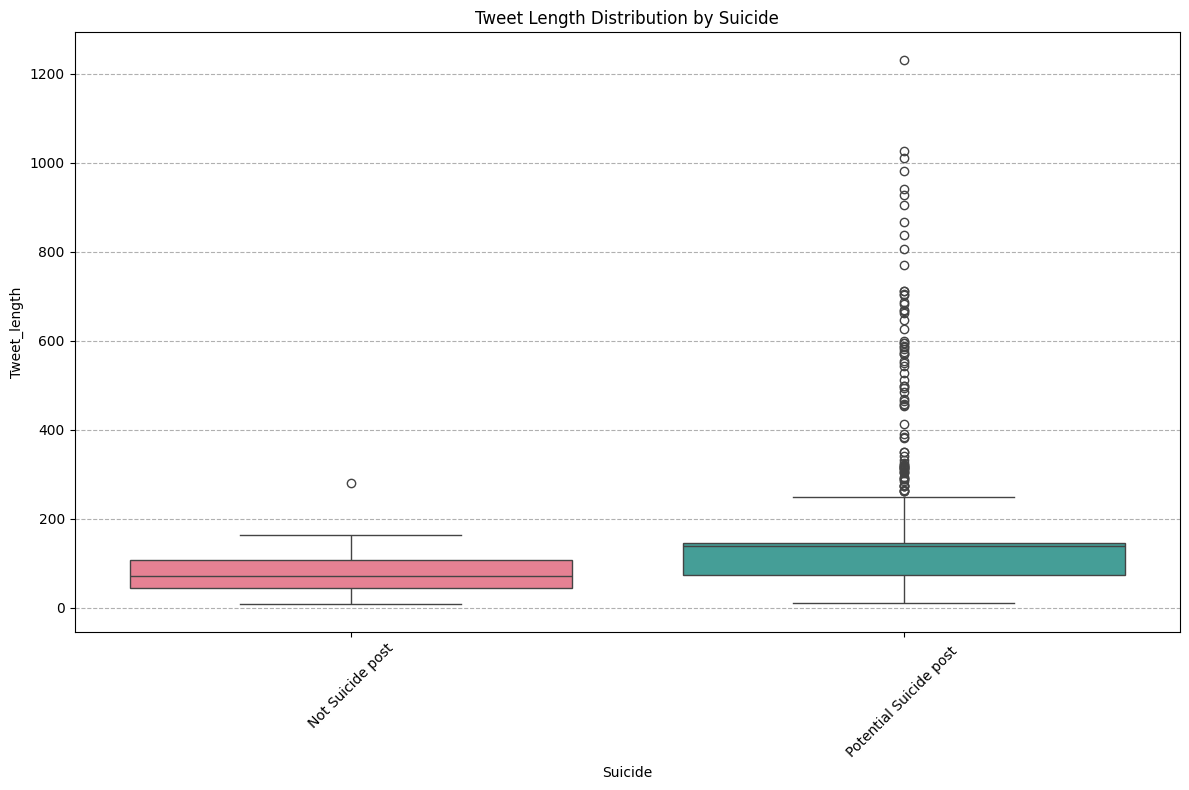

In [11]:
df['Tweet_length'] = df['Tweet'].apply(len)
Tweet_length_stats = df['Tweet_length'].describe()

# Plotting Tweet Length Distribution by Suicide
plt.figure(figsize=(12, 8))
sns.boxplot(x='Suicide', y='Tweet_length', data=df,  palette='husl')
plt.title('Tweet Length Distribution by Suicide')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

Dari Visualisasi diatas dapat dilihat persebaran jumlah kata pada Tweet pada rentang 1 hingga 200 kata sebagai mayoritas sedangkan sisanya dapat dianggap sebagai outlier

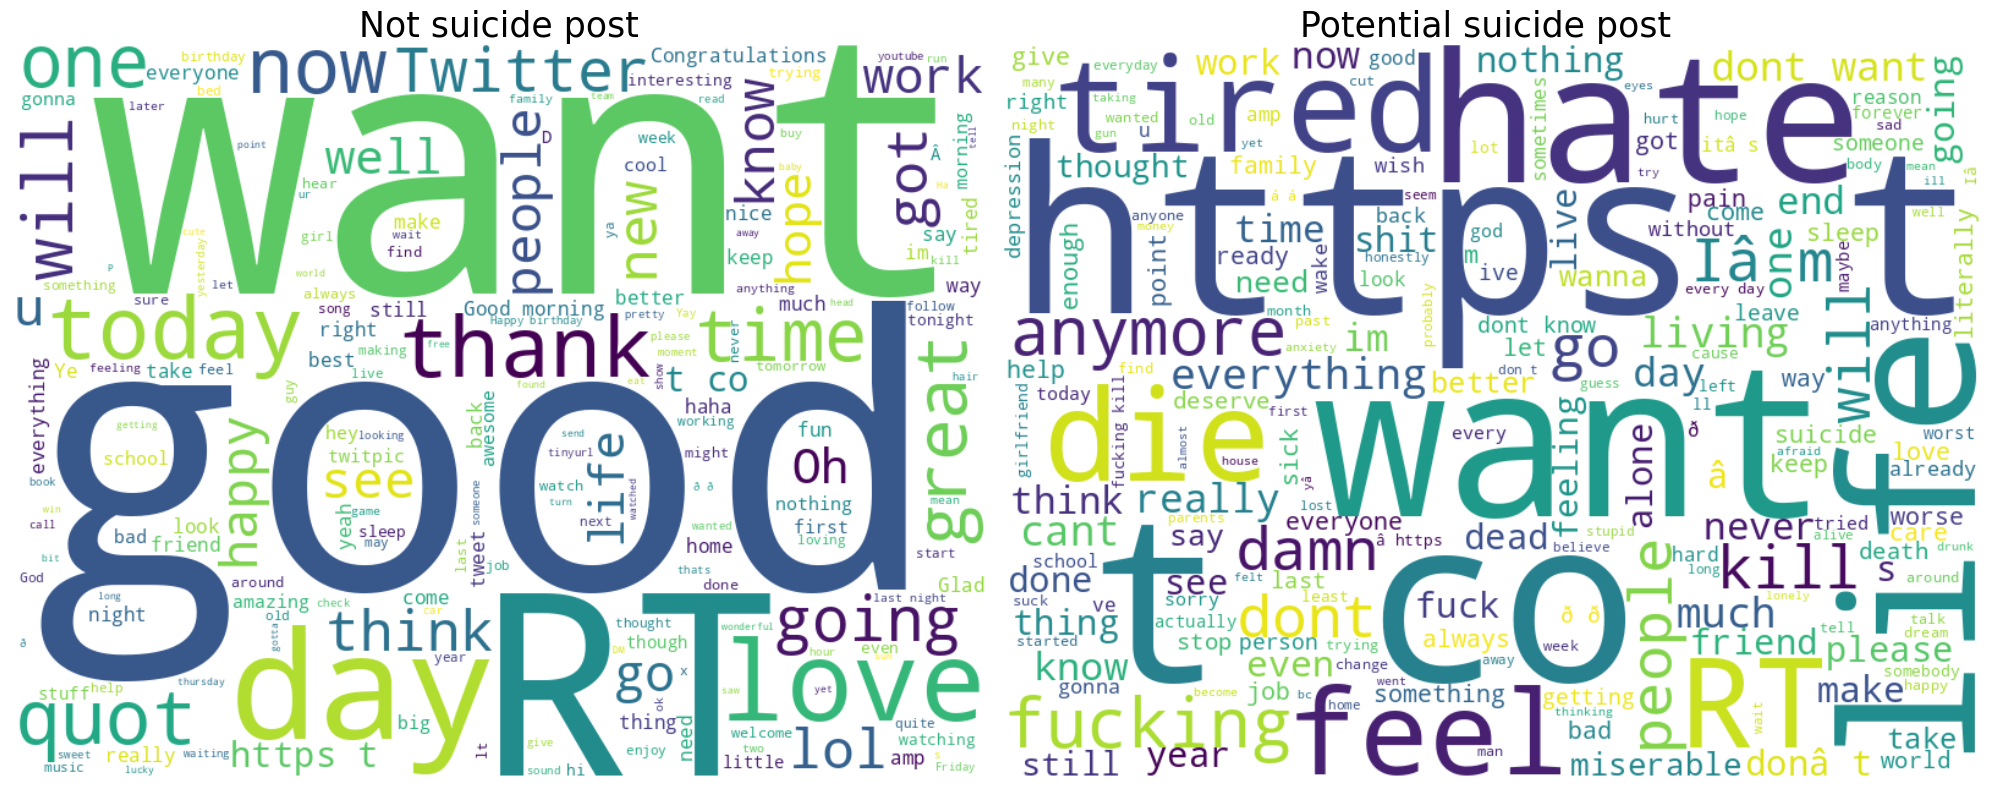

In [12]:
# Prepare the text for tweet state
tweet_by = df.groupby('Suicide')['Tweet'].apply(lambda x: ' '.join(x)).to_dict()

# Set up the subplots for tweet state
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))  # Adjust the size and layout as needed
axes = axes.flatten()

for i, (emotion, text) in enumerate(tweet_by.items()):
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(emotion.capitalize(), fontsize=25)

plt.tight_layout()
plt.show()

Berdasarkan visualisasi diatas diperoleh informasi :     
1. Not Suicide Post, didominasi dengan kata want, good, RT, dan beberapa kata lainnya. Kata kata ini dianggap bukan merupakan pola bahasa bunuh diri

2. Potential Suicide Post, didominasi dengan kata hate, tired, kill, fucking dan beberapa kata lainnya. Kata kata ini dinggap merupakan pola bahasa yang berpotensi untuk bunuh diri

# Feature Engineering

## Text Processing

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
# Define Stopwords
from nltk.corpus import stopwords
stpwds_en = list(set(stopwords.words('english')))

In [16]:
# Define Lemmatiizng
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub('@[^a-zA-Z]', ' ', text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Tags removal
  text = re.sub(r'@\w+\s*', '', text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_en]

  #Lemmatizing
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

# Applying Text Preprocessing to the Dataset
df['Tweet_processed'] = df['Tweet'].apply(lambda x: text_preprocessing(x))
df.head()

,Tweet,Suicide,Tweet_length,Tweet_processed
0,making some lunch,Not Suicide post,17,making lunch
1,@Alexia You want his money.,Not Suicide post,27,want money .
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post,86,crap took forever put together . iâm going g...
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post,66,hey jer ! since start twittering ?
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post,143,trying & quot ; delicious library 2 & quot ; m...


## Target Convertion

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['Suicide'] = encoder.fit_transform(df['Suicide'])
df.head()

,Tweet,Suicide,Tweet_length,Tweet_processed
0,making some lunch,0,17,making lunch
1,@Alexia You want his money.,0,27,want money .
2,@dizzyhrvy that crap took me forever to put to...,1,86,crap took forever put together . iâm going g...
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0,66,hey jer ! since start twittering ?
4,Trying out &quot;Delicious Library 2&quot; wit...,0,143,trying & quot ; delicious library 2 & quot ; m...


In [20]:
# Target Distribution

df['Suicide'].value_counts()

0    1126
1     659
Name: Suicide, dtype: int64

## Spliting Data

In [21]:
#df Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.Tweet_processed,
                                                    df.Suicide,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df.Suicide)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1365,)
Val Size   :  (152,)
Test Size  :  (268,)


Berdasarkan data diatas diketahui jumlah masing - masing data pada variabel X sebagai berikut:

- Train: 1365 baris
- Val : 152 baris
- Test : 268 baris

## Vectorizing

In [22]:
# Get Vocabularies
from sklearn.feature_extraction.text import CountVectorizer
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<1365x4160 sparse matrix of type '<class 'numpy.int64'>'
	with 13289 stored elements in Compressed Sparse Row format>

Vectorizer digunakan untuk mengonversi koleksi dokumen teks menjadi vektor fitur berdasarkan frekuensi kata-kata.Vectorize yang digunakan adalah CountVectorizer, digunakan untuk mengubah teks menjadi representasi numerik yang dapat digunakan sebagai input untuk model deep learning

In [23]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  4160
Maximum Sentence Length :  100 tokens


In [24]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [25]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'want',
 'http',
 'like',
 'rt',
 'life',
 's',
 'dont',
 'hate',
 'tired',
 'day',
 'm',
 'get',
 'die',
 'nt',
 'good',
 'fucking',
 'know',
 'go']

## Word Embedding

In [26]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

Word Embedding untuk merepresentasikan kata-kata dalam bentuk vektor numerik di dalam ruang berdimensi rendah yang mempertahankan struktur semantik dan hubungan antarkata. Ini memungkinkan komputer untuk memahami makna kata-kata dan hubungannya dengan kata-kata lainnya dalam konteks.

# LSTM Sequential

## Model Definition and Training

In [27]:
# using LSTM
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.layers import BatchNormalization

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Model Definition
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.5))
model_lstm_1.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.5))

# Tambahkan lapisan BatchNormalization untuk mengurangi overfitting
model_lstm_1.add(BatchNormalization())

model_lstm_1.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_lstm_1.summary()

# Model Training
# Gunakan callback EarlyStopping untuk menghindari overfitting
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 128)          532480    
                                                                 
 bidirectional (Bidirection  (None, 100, 32)           18560     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                2624      
 onal)                                                           
                                                        

## Model Evaluation

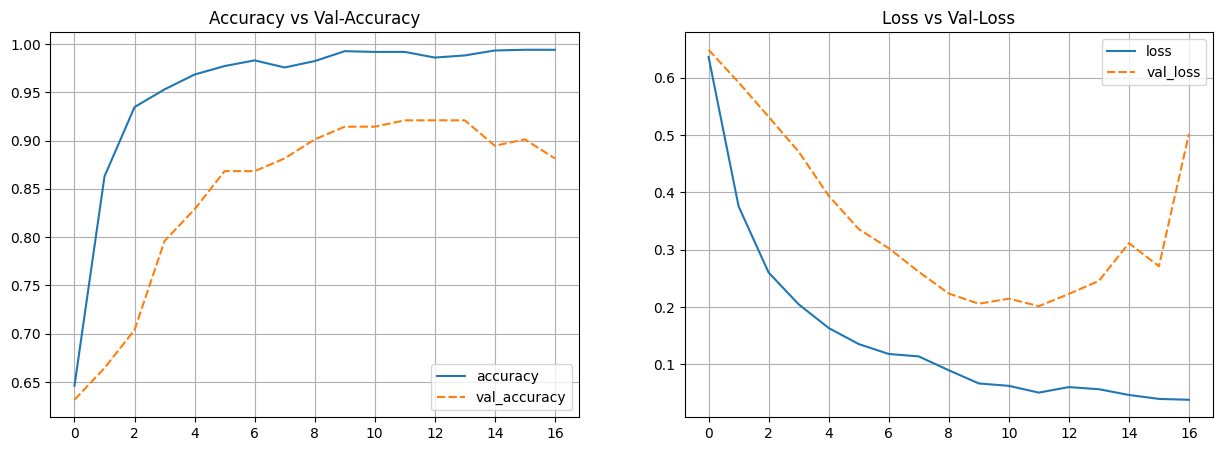

In [28]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Analysis :    
- LSTM (Long Short-Term Memory) digunakan untuk memprediksi atau memahami teks panjang dan membantu model untuk mengerti cerita atau teks dengan lebih baik.
- Penggunaan dropout 0.5 membantu menghaslkan accuracy model yang lebih baik dibanding 0.1
- Diterapkan jumlah hidden layer dan neuron sedikit, untuk meminimalisasi runtime, mengingat dataset yang cukup besar
- Penggunaan Batch Normalization berguna untuk mengurangi overfitting

* Grafik yang ditampilkan sudah baik dengan kondisi awal yang underfitting kemudian mulai goodfit pada epoch = 8 dan pada epoch = 15 mulai mengalami overfitting


In [29]:
# Model Evaluation (test-set)

y_pred_seq = model_lstm_1.predict(X_test)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, y_pred_seq), '\n')
print('Clasification Report: \n', classification_report(y_test, y_pred_seq), '\n')

9/9 [==============================] - 2s 23ms/step
Accuracy:  0.9402985074626866 

Clasification Report: 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       169
           1       0.99      0.85      0.91        99

    accuracy                           0.94       268
   macro avg       0.95      0.92      0.93       268
weighted avg       0.94      0.94      0.94       268
 



# LSTM Sequential with Transfer Learning

## Model Definition and Model Training

In [30]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/nnlm-en-dim128/2'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Reshape

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Dense(1, activation='sigmoid'))  # Menggunakan aktivasi 'sigmoid' untuk klasifikasi biner

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Menyesuaikan learning rate
model_lstm_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_lstm_2.summary()

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          33792     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

## Model Evaluation

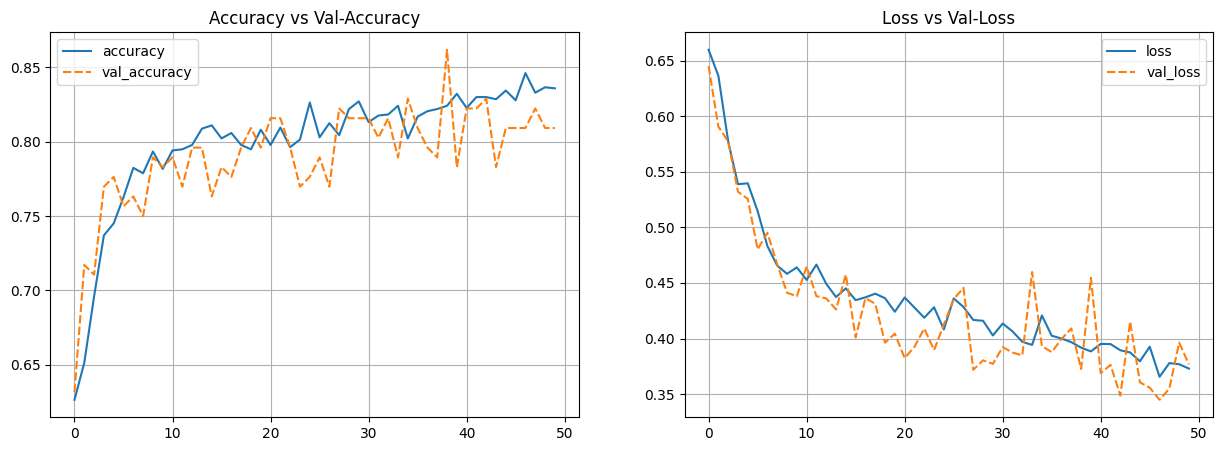

In [32]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

Analysis :    
- Penggunaan transfer learning meningkatkan performa model untuk mempertahankan data agar tetap goodfit namun terjadi penurun accuracy dibandingkan model yang tidak menggunakan transfer learning

* Grafik yang ditampilkan sudah baik dengan kondisi awal yang underfitting,  Adapun kedua grafik menunjukkan peningkatan, yang berarti setiap peningkatan epochs maka accuracy model akan meningkat. Oleh karena itu, model improvement sudah dapat dikatakan goodfit (dengan toleransi 0.1)

In [33]:
# Model Evaluation (test-set)

y_pred_seq = model_lstm_2.predict(X_test)
y_pred_seq = np.where(y_pred_seq >= 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, y_pred_seq), '\n')
print('Clasification Report: \n', classification_report(y_test, y_pred_seq), '\n')

9/9 [==============================] - 2s 46ms/step
Accuracy:  0.832089552238806 

Clasification Report: 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       169
           1       0.78      0.76      0.77        99

    accuracy                           0.83       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268
 



# Model Saving

In [34]:
# Model summary

model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          33792     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [35]:
# Freeze model

model_lstm_2.trainable = False
model_lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          33792     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [39]:
#Saving model

model_lstm_2.save('model_nlp_final', save_format='tf')

# Kesimpulan

1. Proses modeling menggunakan 2 metode yaitu LSTM dan LSTM dengan Transfer Learning. Model LSTM dengan transfer learning menampilkan visualisai dengan baik yang mempertahankan data agar tetap goodfit namun sulit untuk meningkatkan accuracy dibanding model yang tidak menggunakan transfer learning

2. Melalui Visualisasi pada EDA didapatkan kata kata yang 2 kategori yaitu kata kata yang memiliki pola berpotensi bunuh diri dan kata kata yang tidak memiliki potensi bunuh diri